In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import heapq
import math
import json

In [495]:
map_name ="com1building"
resolution, world_width, world_height, map = pickle.load(open("./org_map/%s.pkl" % (map_name), "rb")) 
ROBOT_SIZE = 0.2552

In [496]:
map_a = np.array(map).reshape(world_height, world_width)
map_a[0, :] = 100
map_a[-1, :] = 100
map_a[:, 0] = 100
map_a[:, -1] = 100

# inflation_ratio = int(np.ceil(ROBOT_SIZE * 1/resolution)//2)+1
robot_diag = (2* (ROBOT_SIZE**2))**0.5
inflation_ratio =  int(np.ceil(robot_diag/resolution/2))
    
mv = [0, 1, 2]
for k in range(inflation_ratio):
    map_a = np.pad(map_a, 1)
    maps = [map_a[i:world_height+i, j:world_width+j] for i in mv for j in mv]
    maps_padded = np.stack(maps).sum(axis=0)
    map_a = (maps_padded > 0) * 100

aug_map = map_a

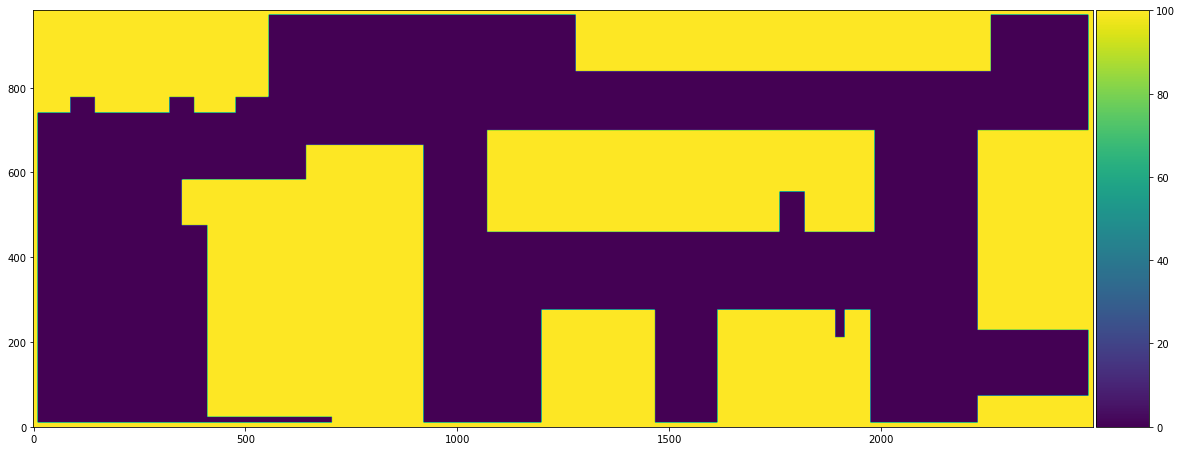

In [498]:
map_base = np.array(map).reshape(world_height, world_width)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(aug_map, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


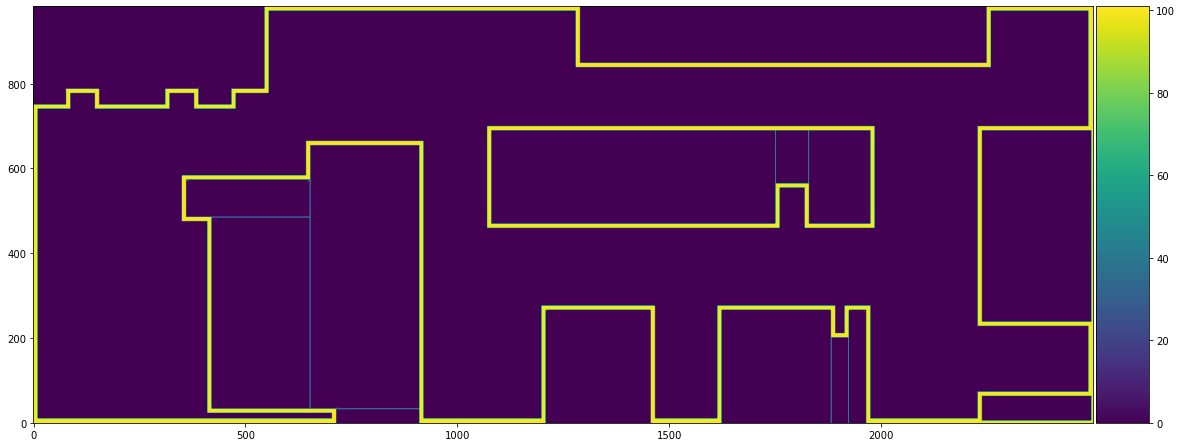

In [499]:
map_base = np.array(map).reshape(world_height, world_width)
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(map_a-map_base, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


In [9]:
def l1_dist(pose, goal):
    """Compute L1 distance from pose to goal.

    Arguments:
        pose {list} -- robot pose
        goal {list} -- goal pose

    Returns:
        float -- L1 distance to the target_pose
    """
    #TODO: add tie breaking
    l1_dist = np.abs(np.subtract(pose[:2], goal[:2])).sum()
    return l1_dist

def l2_dist(pose, goal):
    """Compute L2 distance from pose to goal.

    Arguments:
        pose {list} -- robot pose
        goal {list} -- goal pose

    Returns:
        float -- L2 distance to the target_pose
    """
    return math.sqrt(
        (pose[0] - goal[0]) ** 2 + (pose[1] - goal[1]) ** 2
    )
    
def normalize_theta(a):
    while( a < -np.pi): a += 2.0*np.pi
    while( a >  np.pi): a -= 2.0*np.pi
    return a

def arr_checker(pose):
    if type(pose) != np.ndarray:
        return np.array(pose)
    else:
        return pose
        
def perfect_next_state(cur_pose, control, dt=0.1, num_times=5):
    # Each control exert for 0.5 seconds and refresh rate for env is 0.1 (new position is is calculated every 0.1s) 
    v, w = control[0], control[1]
    cur_pose = arr_checker(cur_pose) 
    for _ in range(num_times):
        theta = cur_pose[-1]
        delta_mv = np.array([
            v*np.cos(theta),
            v*np.sin(theta),
            w
        ]) * dt
        cur_pose = cur_pose + delta_mv    
        cur_pose[-1] = normalize_theta(cur_pose[-1])
    # return np.round(cur_pose, 6)
    return cur_pose
    

def actions_to_take(start, end, cur_theta):
    actions = []
    # turn to face end
    tar_facing = {
        (-1, 0): 2, 
        (1, 0): 0, 
        (0, -1): 3,
        (0, 1): 1,
    }
    delta = tuple((end - start).tolist())
    tar_theta = tar_facing[delta]
    if (tar_theta - 1) % 4 == cur_theta:
        actions.append((0, 1)) #turn left
    else:
        while (cur_theta != tar_theta):
            actions.append((0, -1)) #turn right
            cur_theta = (cur_theta - 1) % 4                
    actions.append((1,0))
    return actions, tar_theta


            
def sample_pts(cp_x_y, ns_x_y, density=2):
    cp_x_y = arr_checker(cp_x_y)
    ns_x_y = arr_checker(ns_x_y)
    dist = l1_dist(cp_x_y, ns_x_y)
    sample_size = int(np.ceil(1.0*dist/density))+1
    seg_sample = np.random.uniform(size=sample_size)
    seg_sample[-1] = 0
    pts_sample = seg_sample * cp_x_y[::-1].reshape(-1, 1) + (1-seg_sample) * ns_x_y[::-1].reshape(-1, 1)
    pts_sample = np.round(pts_sample).astype(np.int)
    pts_sample = set(tuple(u) for u in pts_sample.T)
    return tuple(zip(*pts_sample))           

In [10]:
def collision_checker(x, y):
        """TODO: FILL ME!
        You should implement the collision checker.
        Hint: you should consider the augmented map and the world size
        
        Arguments:
            x {float} -- current x of robot
            y {float} -- current y of robot
        
        Returns:
            bool -- True for collision, False for non-collision
        """
        xy = np.round(np.array([x, y]) / resolution).astype(int)
        return ((xy < 0).any() or xy[0] >= world_width or xy[1] >= world_height) or  aug_map[xy[1], xy[0]] > 0
        
def motion_predict(x, y, theta, v, w, dt=0.5, frequency=10):
    num_steps = int(dt * frequency)
    dx = 0
    dy = 0
    for i in range(num_steps):
        if w != 0:
            dx = - v / w * np.sin(theta) + v / w * \
                np.sin(theta + w / frequency)
            dy = v / w * np.cos(theta) - v / w * \
                np.cos(theta + w / frequency)
        else:
            dx = v*np.cos(theta)/frequency
            dy = v*np.sin(theta)/frequency
        x += dx
        y += dy

        theta += w / frequency
    return x, y, theta

def discrete_motion_predict(x, y, theta, v, w, dt=0.5, frequency=10):
    w_radian = w * np.pi/2
    first_step = motion_predict(x, y, theta*np.pi/2, v, w_radian)
    if first_step:
        second_step = motion_predict(
            first_step[0], first_step[1], first_step[2], v, w_radian)
        if second_step:
            return (round(second_step[0]), round(second_step[1]), round(second_step[2] / (np.pi / 2)) % 4)
    return None

In [11]:
def next_state(cur_pose, control, dt=0.1, num_times=5, oob=True):
    # Each control exert for 0.5 seconds and refresh rate for env is 0.1 (new position is is calculated every 0.1s) 
    v, w = control[0], control[1]
    next_pose = discrete_motion_predict(cur_pose[0], cur_pose[1], cur_pose[2], v, w)
    next_pose = arr_checker(next_pose)
    if (not oob) and (collision_checker(*cur_pose[:2]) or collision_checker(*next_pose[:2])):
        return arr_checker(cur_pose)
    return next_pose

def get_aug_coord(pose, multiplier):
    pose = arr_checker(pose) 
    rtn = pose * multiplier
    rtn = np.round(rtn).astype(np.int)[:-1]
    return rtn

def xy2ij(xy_coord):
    return (xy_coord[1], xy_coord[0]) + xy_coord[2:]

In [504]:
multiplier = int(1/resolution)
init_pose = (1, 1, 0) #(4, 4, 2)
goal_init = (48, 18)
aug_map = map_a

init_pose_a = np.array(init_pose).astype(int)
goal = np.array(goal_init).astype(int)
num_y, num_x = int(world_height * resolution)+1, int(world_width * resolution)+1
num_t = 4
num_action = 4
T_max = 10000

In [514]:
# s00, s01, s0-1, s10, s11, s1-1
t_matrix = np.array([
    [1, 0, 0, 0,   0,    0],
    [0, 1, 0, 0,   0,    0],
    [0, 0, 1, 0,   0,    0],
    [0, 0, 0, 0.9, 0.05, 0.05],
])
state_prev = np.zeros((num_y, num_x, num_t))

actions_space = [(0, 0), (0, 1), (0, -1), (1, 0)]
movements = np.array(actions_space + [(1, 1), (1, -1)])
yv, xv, tv = np.meshgrid(range(num_y), range(num_x), range(num_t), indexing='ij') 
yv, xv, tv = yv.reshape(-1), xv.reshape(-1), tv.reshape(-1)
all_states = list(zip(xv, yv, tv))
all_s_next = np.array([[next_state(pose, c, oob=False) for c in movements] for pose in all_states]) #x,y
all_s_next = all_s_next.reshape(num_y, num_x, num_t, *all_s_next.shape[1:]) # (y,x,t) : (x,y,t)
all_s_next = all_s_next.astype(np.int)
s_next_idx = tuple(tuple(states) for states in all_s_next.reshape(-1, 3).T)
s_next_idx = s_next_idx[1], s_next_idx[0], s_next_idx[2] #(y, x, t)

In [515]:
invalid_actions = np.zeros((num_x, num_y, num_t))
rewards = np.zeros((num_x, num_y, num_t, num_action))
t_matrix_ = np.repeat(t_matrix[np.newaxis, ...], np.prod((num_x, num_y, num_t)), axis=0)
t_matrix_ = t_matrix_.reshape(num_x, num_y, num_t, 4, 6)

# pt_samples_ls = []

for pose in all_states:
    cp_x_y = get_aug_coord(pose, multiplier)
    r_for_cur = np.zeros(6) - 1
    for cid, c in enumerate(movements):
        next_s = next_state(pose, c)
        ns_x_y = get_aug_coord(next_s, multiplier)
        pt_samples = sample_pts(cp_x_y, ns_x_y, density=1)
        if ((cp_x_y < 0).any() or cp_x_y[0] >= world_width or cp_x_y[1] >= world_height) or \
            ((ns_x_y < 0).any() or ns_x_y[0] >= world_width or ns_x_y[1] >= world_height) or \
            aug_map[pt_samples].sum() > 0: 
                r_for_cur[cid] = -25 # -8 #.*num_y*num_x 
                t_matrix_[pose][:, cid] = 0
    # if pose[:2] == (47, 18) and cid >= 3: 
    #     pt_samples_ls.append((cid, c, pose, cp_x_y, next_s, ns_x_y, pt_samples))
    invalid_actions[pose] = r_for_cur[3]
    rewards[pose] = np.matmul(t_matrix, r_for_cur) 

invalid_actions = np.transpose(invalid_actions, (1, 0, 2))  
invalid_actions = invalid_actions < -1
rewards = np.transpose(rewards, (1, 0, 2, 3))
# -1 for all except goal states for no action
rewards[goal[1], goal[0], :, 0] = 0
t_matrix_ = np.transpose(t_matrix_, (1, 0, 2, 3, 4))
norm = t_matrix_.sum(-1)
norm[norm==0] = 1
t_matrix_ = t_matrix_/norm[...,np.newaxis]       

invalid_nodes = np.zeros((num_y, num_x)).astype(np.bool)
for i in range(num_y):
    for j in range(num_x):
        y, x = i*multiplier, j*multiplier
        if x >= world_width or y >= world_height or aug_map[y, x] == 100:
            invalid_nodes[i, j] = True

In [516]:
for t in range(T_max):
    # 1 iteration of value propagation
    v_prev = state_prev[s_next_idx].reshape(-1, 1)
    v_prev = v_prev.reshape(*(all_s_next.shape[:-1] + (1,)))
    v_prev = np.matmul(t_matrix_, v_prev).squeeze()
    q_values = rewards + v_prev
    q_values[:,:,:,3][invalid_actions] = np.nan
    q_values[:,:,:,0] = np.nan
    q_values[goal[1],goal[0],:,0] = 0
    v_cur = np.nanmax(q_values, axis=-1)
    # v_cur = np.max(q_values, axis=-1)
    v_cur[invalid_nodes] = 0
    old_state_prev = state_prev
    state_prev = v_cur
    if np.isclose(old_state_prev, v_cur).all():
        print("close", t)
        break
action_table = {pose:actions_space[np.nanargmax(q_values[xy2ij(pose)])] for pose in all_states}    

close 112


In [509]:
x, y = 31, 15
print(t_matrix_[y, x])
rewards[y,x]

[[[1.   0.   0.   0.   0.   0.  ]
  [0.   1.   0.   0.   0.   0.  ]
  [0.   0.   1.   0.   0.   0.  ]
  [0.   0.   0.   0.9  0.05 0.05]]

 [[1.   0.   0.   0.   0.   0.  ]
  [0.   1.   0.   0.   0.   0.  ]
  [0.   0.   1.   0.   0.   0.  ]
  [0.   0.   0.   0.9  0.05 0.05]]

 [[1.   0.   0.   0.   0.   0.  ]
  [0.   1.   0.   0.   0.   0.  ]
  [0.   0.   1.   0.   0.   0.  ]
  [0.   0.   0.   0.9  0.05 0.05]]

 [[1.   0.   0.   0.   0.   0.  ]
  [0.   1.   0.   0.   0.   0.  ]
  [0.   0.   1.   0.   0.   0.  ]
  [0.   0.   0.   0.9  0.05 0.05]]]


array([[-1., -1., -1., -1.],
       [-1., -1., -1., -1.],
       [-1., -1., -1., -1.],
       [-1., -1., -1., -1.]])

In [517]:
x, y = 31, 14
q_values[y, x], v_cur[y, x], v_prev[y, x]

(array([[         nan, -30.12120963, -32.12120963, -30.81594647],
        [         nan, -31.12120963, -31.12120963, -29.12120963],
        [         nan, -32.12120963, -30.12120963, -33.61594647],
        [         nan, -31.12120963, -31.12120963,          nan]]),
 array([-30.12120963, -29.12120963, -30.12120963, -31.12120963]),
 array([[-30.12120963, -29.12120963, -31.12120963, -28.61594647],
        [-29.12120963, -30.12120963, -30.12120963, -28.12120963],
        [-30.12120963, -31.12120963, -29.12120963, -31.41594647],
        [-31.12120963, -30.12120963, -30.12120963,   0.        ]]))

In [511]:
x, y = 31, 14
q_values[y, x], v_cur[y, x], v_prev[y, x]

(array([[         nan, -28.04643113, -29.31887877, -27.31887877],
        [         nan, -29.04643113, -28.31887877, -27.04643113],
        [         nan, -29.31887877, -28.04643113, -30.565617  ],
        [         nan, -28.31887877, -29.04643113,          nan]]),
 array([-27.31887877, -27.04643113, -28.04643113, -28.31887877]),
 array([[-27.31887877, -27.04643113, -28.31887877, -25.96887877],
        [-27.04643113, -28.04643113, -27.31887877, -26.04643113],
        [-28.04643113, -28.31887877, -27.04643113, -29.215617  ],
        [-28.31887877, -27.31887877, -28.04643113,   0.        ]]))

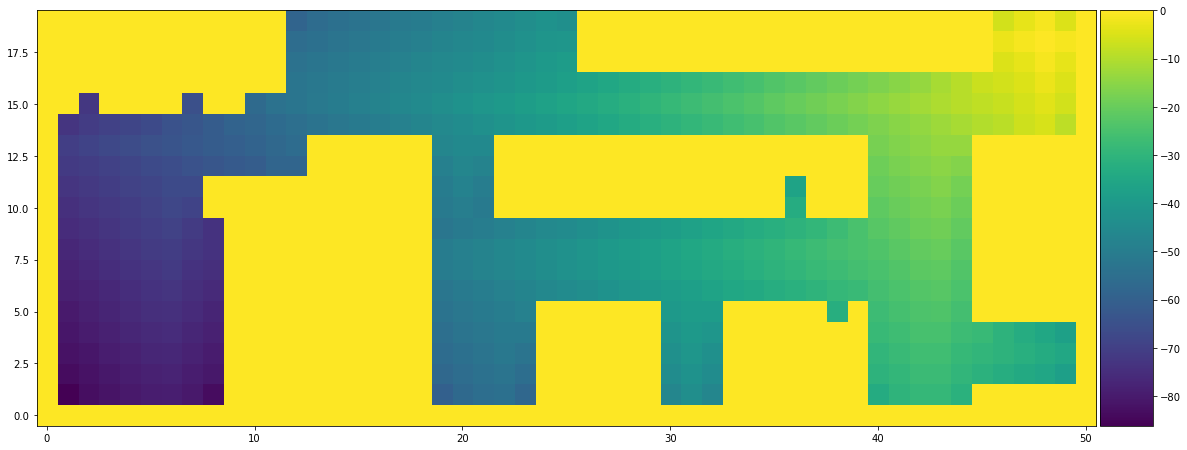

In [518]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(v_cur.max(-1), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

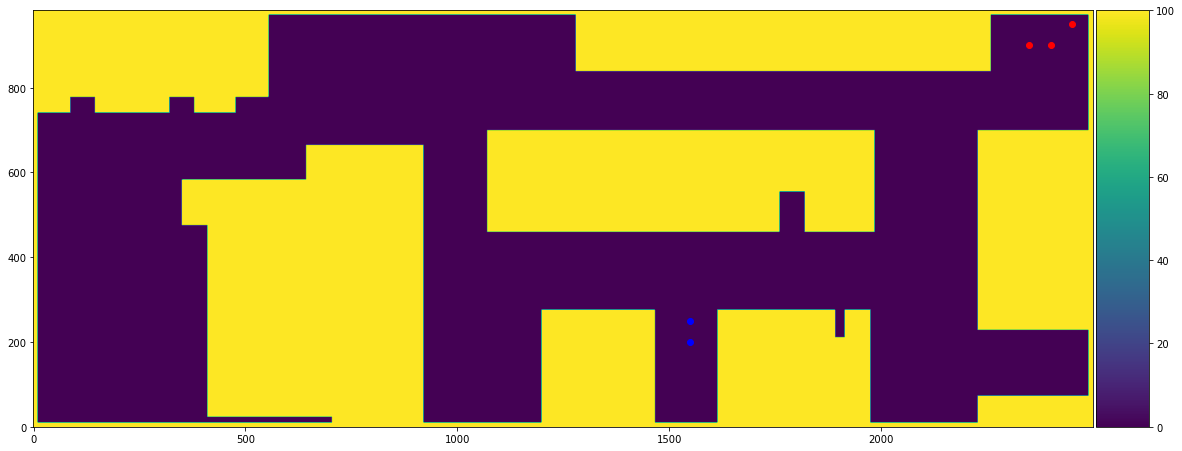

In [133]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(aug_map, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

x, y = 47, 18
ax.plot(x*multiplier, y*multiplier, "ro")
x, y = 48, 18
ax.plot(x*multiplier, y*multiplier, "ro")
x, y = 49, 19
ax.plot(x*multiplier, y*multiplier, "ko")
x, y = 31, 4
ax.plot(x*multiplier, y*multiplier, "bo")
x, y = 31, 5
ax.plot(x*multiplier, y*multiplier, "bo")

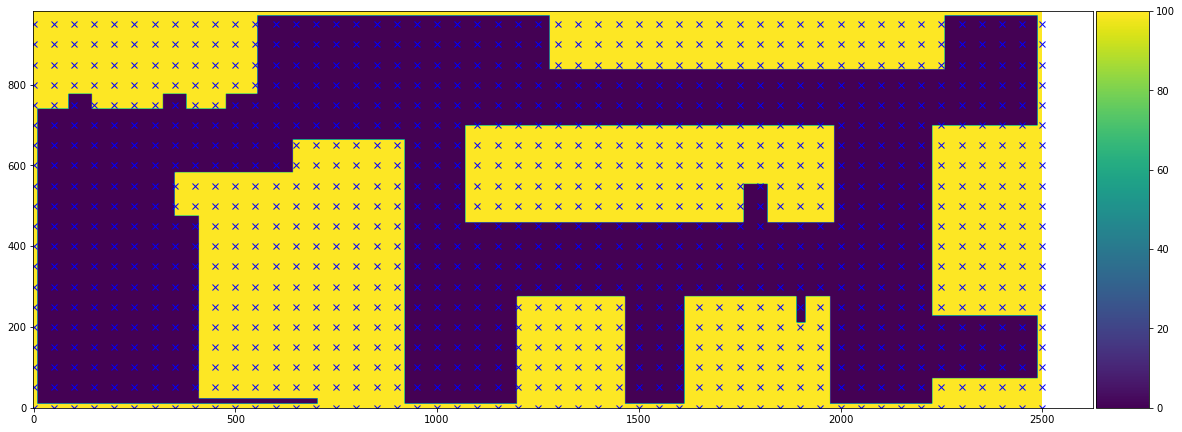

In [141]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(aug_map, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

for y in range(num_y):
    for x in range(num_x):
        ax.plot(x*multiplier, y*multiplier, "bx")

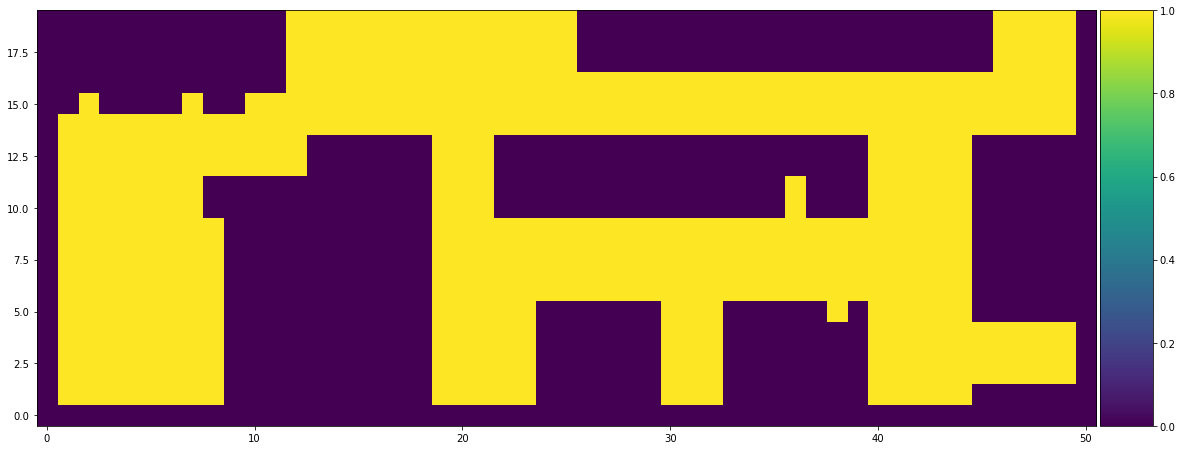

In [148]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(invalid_nodes, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# Simulation

(1, 1, 0) [2 1 0] [1, 0]
(2, 1, 0) [2 1 1] [0, 1]
(2, 1, 1) [2 2 1] [1, 0]
(2, 2, 1) [2 3 1] [1, 0]
(2, 3, 1) [2 4 1] [1, 0]
(2, 4, 1) [2 5 1] [1, 0]
(2, 5, 1) [2 6 1] [1, 0]
(2, 6, 1) [2 7 1] [1, 0]
(2, 7, 1) [2 8 1] [1, 0]
(2, 8, 1) [2 9 1] [1, 0]
(2, 9, 1) [ 2 10  1] [1, 0]
(2, 10, 1) [ 2 11  1] [1, 0]
(2, 11, 1) [ 2 12  1] [1, 0]
(2, 12, 1) [ 2 13  1] [1, 0]
(2, 13, 1) [ 2 13  0] [0, -1]
(2, 13, 0) [ 3 13  0] [1, 0]
(3, 13, 0) [ 4 13  0] [1, 0]
(4, 13, 0) [ 5 13  0] [1, 0]
(5, 13, 0) [ 6 13  0] [1, 0]
(6, 13, 0) [ 7 13  0] [1, 0]
(7, 13, 0) [ 8 13  0] [1, 0]
(8, 13, 0) [ 9 13  0] [1, 0]
(9, 13, 0) [10 13  0] [1, 0]
(10, 13, 0) [11 13  0] [1, 0]
(11, 13, 0) [12 13  0] [1, 0]
(12, 13, 0) [12 13  1] [0, 1]
(12, 13, 1) [12 14  1] [1, 0]
(12, 14, 1) [12 15  1] [1, 0]
(12, 15, 1) [12 15  0] [0, -1]
(12, 15, 0) [13 15  0] [1, 0]
(13, 15, 0) [14 15  0] [1, 0]
(14, 15, 0) [15 15  0] [1, 0]
(15, 15, 0) [16 15  0] [1, 0]
(16, 15, 0) [17 15  0] [1, 0]
(17, 15, 0) [18 15  0] [1, 0]
(18, 15, 0) 

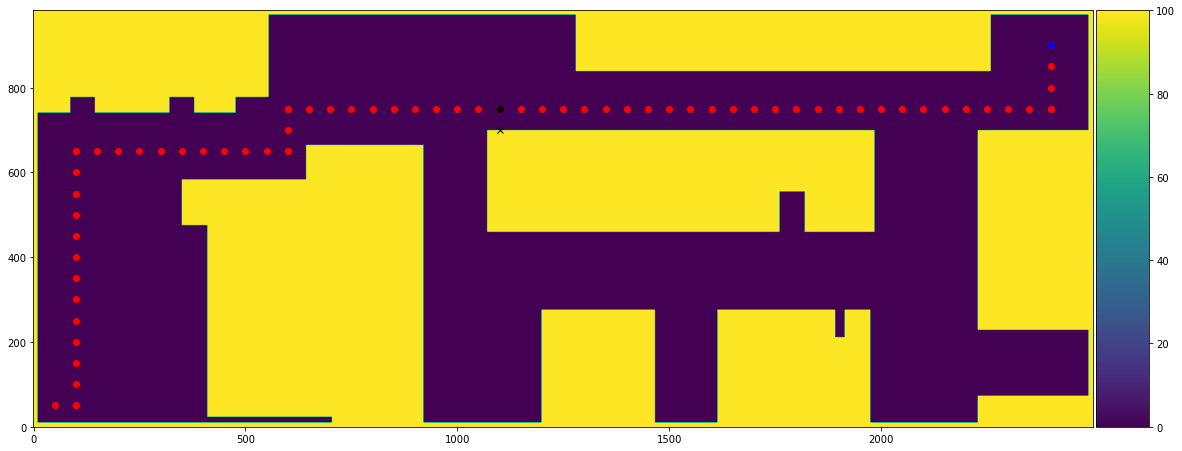

In [68]:
ROBOT_SIZE = 0.2552
map_name = "com1building"
goal = 5

goals = {
    "map1" : [[3, 5], [8, 8], [7, 6]],
    "map2" : [[5, 5], [9, 8], [3, 3]],
    "map3" : [[9, 7], [4, 5], [5, 7]],
    "map4" : [[5, 4], [9, 9], [8, 3]],
    "com1building" : [[4, 8], [31, 4], [49, 3], [30, 16], [20, 1], [48, 18]]
}

goal = goals[map_name][goal]
resolution, world_width, world_height, map = pickle.load(open("./org_map/%s.pkl" % (map_name), "rb")) 
multiplier = int(1/resolution)
map_base = np.array(map).reshape(world_height, world_width)

action_table = json.load(open("./Controls/DSPA_%s_%s_%s.json" % (map_name, *goal), "rb"))
action_table = {eval(k): v for k,v in action_table.items()}

##################################################
cur_pose = (1,1,0) #init_pose
path = [cur_pose]
for _ in range(100):
    c = action_table[cur_pose]
    next_s = next_state(cur_pose, c)
    print(cur_pose, next_s, c)
    if cur_pose == tuple(e for e in next_s):
        break
    cur_pose = tuple(e for e in next_s)
    path.append(cur_pose)

##################################################
map_a = np.array(map).reshape(world_height, world_width)
map_a[0, :] = 100
map_a[-1, :] = 100
map_a[:, 0] = 100
map_a[:, -1] = 100

# inflation_ratio = int(np.ceil(ROBOT_SIZE * 1/resolution)//2)+1
robot_diag = (2* (ROBOT_SIZE**2))**0.5
inflation_ratio =  int(np.ceil(robot_diag/resolution/2))
    
mv = [0, 1, 2]
for k in range(inflation_ratio):
    map_a = np.pad(map_a, 1)
    maps = [map_a[i:world_height+i, j:world_width+j] for i in mv for j in mv]
    maps_padded = np.stack(maps).sum(axis=0)
    map_a = (maps_padded > 0) * 100

aug_map = map_a

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(aug_map, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

for x, y, _ in path:
    ax.plot(x*multiplier, y*multiplier, "ro")
x, y = goal[:2]
ax.plot(x*multiplier, y*multiplier, "bo")
x, y = 22, 15
ax.plot(x*multiplier, y*multiplier, "ko")
x, y = 22, 14
ax.plot(x*multiplier, y*multiplier, "kx")

In [62]:
x, y = 22, 14
aug_map[y*multiplier, x*multiplier]

0

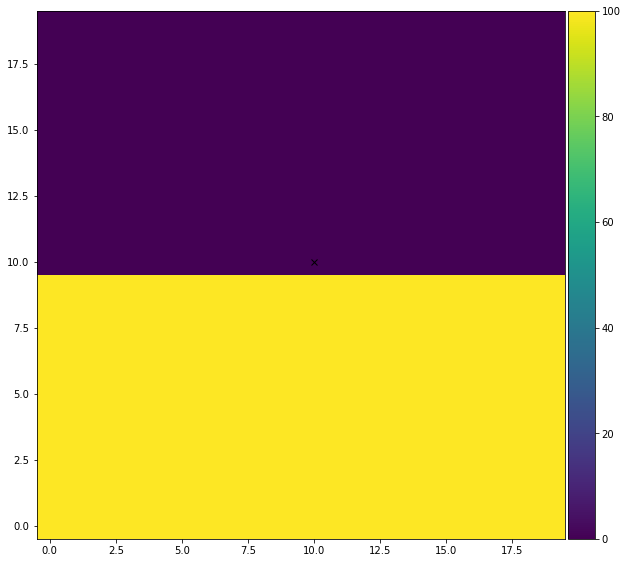

In [66]:
x, y = 22, 14
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(aug_map[y*multiplier-10:y*multiplier+10, x*multiplier-10:x*multiplier+10], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.plot(10, 10, "kx")

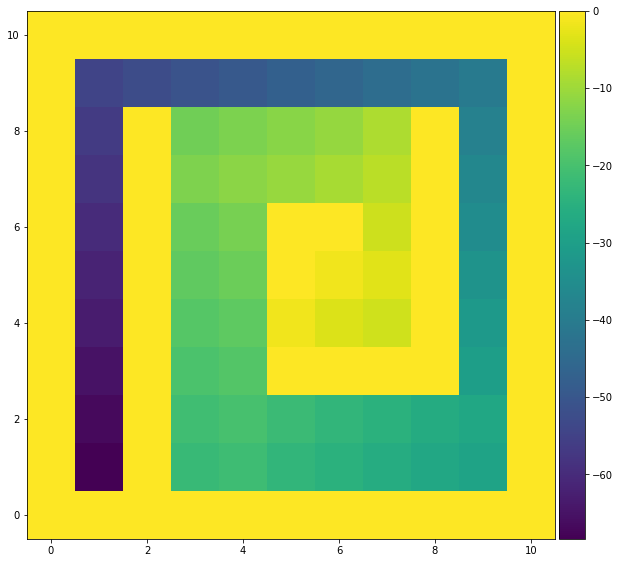

In [465]:
v_cur = pickle.load(open("./state.pkl", "rb"), encoding='latin1') 
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(v_cur.max(-1), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

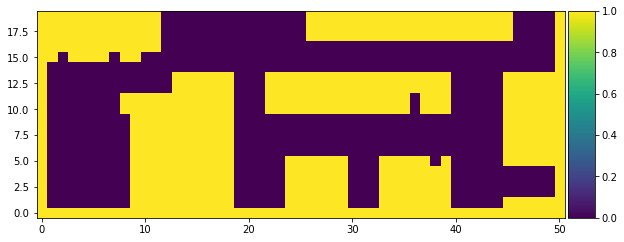

In [397]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(invalid_nodes, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical') 

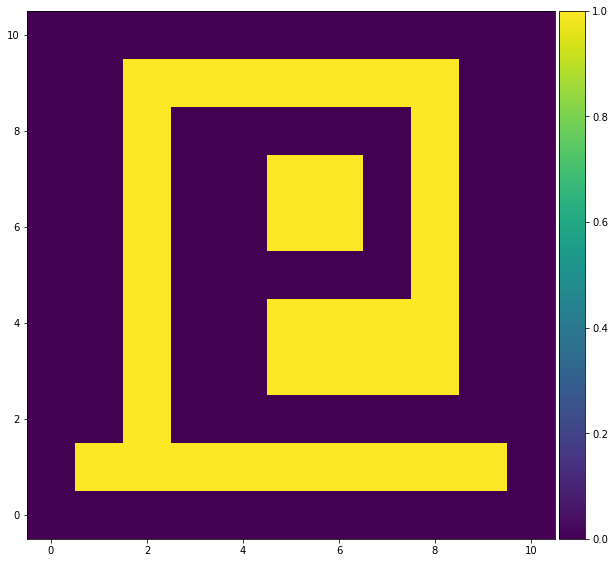

In [1196]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(invalid_actions[:,:,3], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

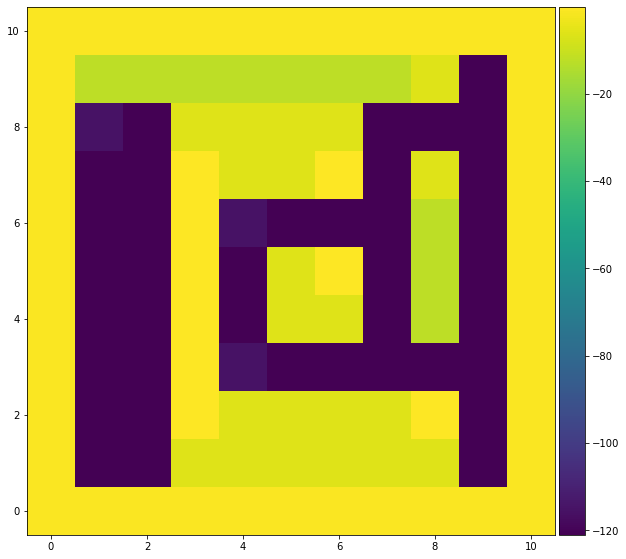

In [1029]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rewards[:, :, 0, 3], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# Compare

In [78]:
import json
PATH="../../../files"
with open(f"{PATH}/task_3.json", "r") as fin:
    policy = json.load(fin)
with open(f"./Controls/DSPA_map3_4_5.json", "r") as fin:
    policy2 = json.load(fin)